In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy as sp
from scipy.special import logsumexp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 


# Libraries used during sorting procedures.
import heapq # <-- Efficient sorting of large lists
import operator # <-- Convienient item retrieval during iteration 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Import the train and test sets
train_df=pd.read_csv("trainOld.csv")
test_df=pd.read_csv("test.csv")

In [3]:
#Glance at train
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
#Glance at test
test_df.head()

,userId,movieId
0,5,788
1,68,7438
2,336,40412
3,803,3822
4,547,903


In [5]:
#Drop timestamp
train_df=train_df.drop(["timestamp"],axis=1)

In [6]:
sampled_df=train_df.sample(n=20000,random_state=2023)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Average rating in dataset: 3.5199


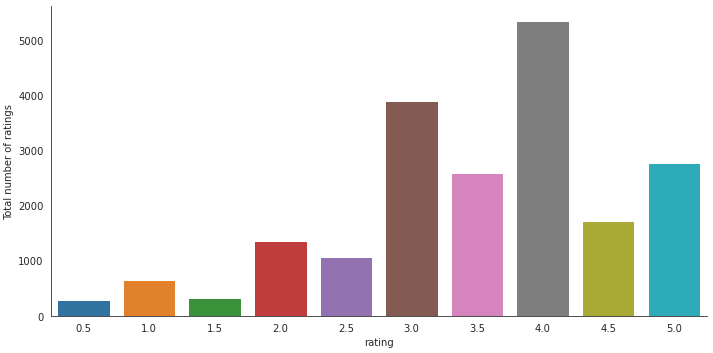

In [7]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=sampled_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(sampled_df["rating"])}')

In [8]:
util_matrix = sampled_df.pivot_table(index=['userId'], 
                                       columns=['movieId'],
                                       values='rating',
                                    fill_value=0,
                                    aggfunc='mean') 

In [9]:
util_matrix 

movieId,1,2,3,4,5,6,7,8,9,10,...,202073,202103,202329,202439,203853,204318,204698,204878,205383,206497
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
3,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
13,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
15,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
41,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162495,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
162508,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
162512,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0


In [10]:
util_matrix_T= util_matrix.T
util_matrix_T = util_matrix_T.loc[:, (util_matrix_T != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_T.values)

In [11]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_T.columns, 
                           columns = util_matrix_T.columns)

# Review a small portion of the constructed similartiy matrix  
user_sim_df[:5]

userId,1,3,13,15,41,43,61,80,82,84,...,162457,162465,162467,162482,162484,162495,162508,162512,162536,162538
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
def collab_generate_top_N_recommendations(userId, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user. 
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalog. 
    if userId not in user_sim_df.columns:
        return train_df.groupby('movieId').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()
    
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=userId, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users
    
    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_T.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_T[util_matrix_T.loc[:, i]==max_score].index.tolist())
        
    # Loop over each user's favorite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]: 
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N  

In [13]:
collab_generate_top_N_recommendations(3)

[111, 41569, 60040]

In [14]:
sampled_df[sampled_df['userId'] == 3][:][['movieId','rating']].sort_values(by='rating', ascending=False)[:10]

,movieId,rating
6044922,111,4.0
9721008,60040,3.0
1488816,41569,3.0


In [92]:
#Function to round predictions to rating scale
def myround(x, base=0.5):
    if x<0.5:
        result=0.5
    elif x>5:
        result = 5.0
    else:
        result=base * round(x/base)
    return result

In [93]:
def collab_generate_rating_estimate(movieId, userId, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    if movieId in util_matrix.columns and userId in user_sim_df.columns:
        sim_users = user_sim_df.sort_values(by=userId, ascending=False).index[1:k+1]
        # Store the corresponding user's similarity values 
        user_values = user_sim_df.sort_values(by=userId, ascending=False).loc[:,userId].tolist()[1:k+1]
        rating_list = [] # <-- List of k user's ratings for the reference item
        weight_list = [] # <-- List of k user's similarities to the reference user

        # Create a weighted sum for each of the k users who have rated the 
        # reference item (book).
        for sim_idx, user_id in enumerate(sim_users):
            # User's rating of the item
            rating = util_matrix.loc[user_id, movieId]
            # User's similarity to the reference user 
            similarity = user_values[sim_idx]
            # Skip the user if they have not rated the item, or are too dissimilar to 
            # the reference user
            if (np.isnan(rating)) or (similarity < threshold):
                continue
            elif not np.isnan(rating):
                rating_list.append(rating*similarity)
                weight_list.append(similarity)
        array1 =np.array(rating_list)
        array2 =np.array(weight_list)
        try:
            # Return the weighted sum as the predicted rating for the reference item
            predicted_rating = np.exp(logsumexp(-3*array1) - logsumexp(-3*array2)) 
        except ZeroDivisionError:
            # If no ratings for the reference item can be collected, return the average 
            # rating given by all users for the item.  
            predicted_rating = sampled_df.loc[sampled_df['movieId'] == movieId, 'rating'].mean()
    elif movieId not in util_matrix.columns and userId in user_sim_df.columns:
        predicted_rating = sampled_df.loc[sampled_df['userId'] == userId, 'rating'].mean()
    elif movieId in util_matrix.columns and userId not in user_sim_df.columns:
        predicted_rating = sampled_df.loc[sampled_df['movieId'] == movieId, 'rating'].mean()
    else:
        predicted_rating = train_df['rating'].mean()
    return myround(predicted_rating)

In [94]:
collab_generate_rating_estimate(3,3)

5.0

In [95]:
movie_id = 5418
actual_rating = train_df[(train_df['userId'] == 2) & (train_df['movieId'] == movie_id)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(movieId = movie_id, userId = 2)
print (f"movieId - {movie_id}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

movieId - 5418
---
Actual rating: 		 5.0
Predicted rating: 	 4.0


In [97]:
s2_df=test_df.sample(n=100,random_state=2023)

In [98]:
s2_df.head()

,userId,movieId
2801,166,2380
486,459,207
6632,252,6537
9165,357,143271
3738,997,101895


In [99]:
s2_df['pred_rating'] = s2_df.apply(lambda x: collab_generate_rating_estimate(x['movieId'], x['userId']), axis=1)

In [100]:
s2_df.head()

,userId,movieId,pred_rating
2801,166,2380,1.0
486,459,207,3.5
6632,252,6537,3.0
9165,357,143271,3.5
3738,997,101895,3.5


In [46]:
test_df.shape

In [101]:
test_df['pred_rating'] = test_df.apply(lambda x: collab_generate_rating_estimate(x['movieId'], x['userId']), axis=1)

In [109]:
def stringer(c, b):
    return str(int(c))+'_'+str(int(b))

In [110]:
test_df['Id'] = test_df.apply(lambda x: stringer(x['userId'], x['movieId']), axis=1)

In [111]:
test_df.shape

(14310, 4)

In [112]:
test_df.head()

,userId,movieId,pred_rating,Id
0,5,788,2.5,5_788
1,68,7438,4.0,68_7438
2,336,40412,4.0,336_40412
3,803,3822,5.0,803_3822
4,547,903,4.0,547_903


In [116]:
outer2 = test_df[['Id','pred_rating']]

In [120]:
outer2.head()

,Id,pred_rating,rating
0,5_788,2.5,2.5
1,68_7438,4.0,4.0
2,336_40412,4.0,4.0
3,803_3822,5.0,5.0
4,547_903,4.0,4.0


In [119]:
outer2['rating']=outer2['pred_rating']

C:\Users\Z7541811\AppData\Local\Temp/ipykernel_18448/2295370166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer2['rating']=outer2['pred_rating']


In [121]:
Hope=outer2.drop(["pred_rating"],axis=1)

In [122]:
Hope.to_csv("UnsupervisedSubmissionF.csv", index=False)